### Graham Kerr
#### graham.s.kerr@NASA.gov; kerrg@cua.edu

<H1 font size="+3" style="color:red">
SPICE (HSR)<br>
-- IRIS - Extract Line Profiles
</H1>
<b>Extract a line profile from the spectrograph data, and write it as a fits file</b>


In [1]:
##
## Import various modules -- can tidy up later
##
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import utils
import os
import re
from scipy import io
import pickle
import cmocean
import copy
import astropy
import pandas as pd
import scipy as sp
from astropy.io import fits
from astropy.io.fits import getheader,getval,getdata


***Set up plot properties***
> - just loads my personal prefs, comment out if you don't have my utils.py

In [2]:
plot_dict = utils.plotsetup(font_size = 18)
plt.rcParams.update(plot_dict)

---
---
---
### <b style="color:blue"> Read in the data </b>
> - Reads a pickle file containing IRIS SG data

In [3]:
#data read in - will take a moment
dir1 = '/Volumes/GrahamKerr_work/OI_IRIS_data/2014_10_25_1500/'
file_sg = dir1+r'IRIS_SG_Oct_25_siiv1394_expcorr.pkl'
with open(file_sg, 'rb') as output:  
    sg_dict = pickle.load(output)


***What is inside this dictionary***

In [4]:
print(sg_dict.keys())

dict_keys(['data', 'wl', 'hdr', 'minx_coord', 'maxx_coord', 'miny_coord', 'maxy_coord', 'slitposx', 'slitposy', 'readme'])


***Dimensions of the data array***

In [5]:
ny = sg_dict['data'].shape[0]
nt = sg_dict['data'].shape[1]
nw = sg_dict['data'].shape[2]
ns = sg_dict['data'].shape[3]

print("Number of slit pixels = ",ny)
print("Number of times = ",nt)
print("Number of wavelengths = ",nw)
print("Number of slit positions = ",ns)


Number of slit pixels =  387
Number of times =  2040
Number of wavelengths =  1020
Number of slit positions =  1


---
---
---
### <b style="color:blue"> Select which line to study </b>
> - Select the wavelengths we are interested in 
> - Select the times we are interested in (i.e. when the flare happens)
> - Select the slit pixels we are interested in (i.e. where the flare is)

***Plot lightcurves of the line of interest***
> - this can show us when and were the line is intense, which is where/when the flare is

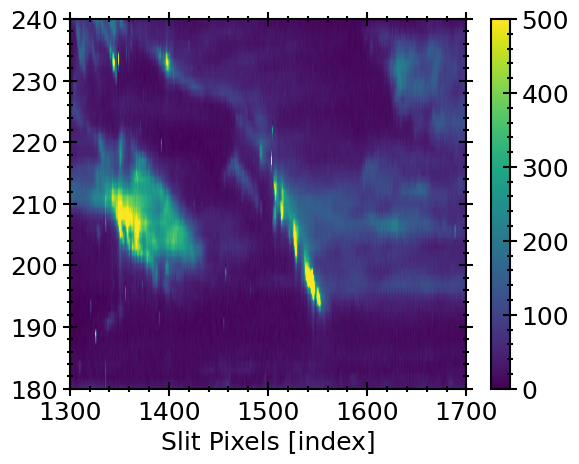

In [6]:
sind = 0 
wl = sg_dict['wl'][:,sind]

lowerlim,upperlim = 1400.95,1401.5  ### O IV 1401.157A 
# lowerlim,upperlim = 1393.4, 1394.7 ### Si IV 1393.755A
# lowerlim,upperlim = 1402.3, 1403.5 ### Si IV 1402.770A

## Select which indices correspond to the lower and upper wavelength values
wind1 = np.abs(wl - lowerlim).argmin()
wind2 = np.abs(wl - upperlim).argmin()
ll = wl[wind1:wind2+1]

### [slit positiion (yind), exposure number (tind), wavelength (wind), slit index (sind)]
yy = sg_dict['data'][:,:,wind1:wind2+1,sind] 
yy_integrated = np.trapz(yy,axis=2)

## These two lines are just my preferences for image plots
plot_dict = utils.plotsetup_image(font_size = 18)
plt.rcParams.update(plot_dict)

## Plot the map, scaled to the 1/4 power to bring out small features. 
## The origin = lower keyword orientates the image in the correct way, since IRIS has the origin in the lower left,
## whereas the python default is top left
## The aspect=auto keyword just keeps the image from being too compressed in one direction
plt.imshow(yy_integrated, origin = 'lower', aspect = 'auto',vmin=0,vmax=500)

## Play with these ranges to look for the flare
plt.xlim(1300,1700)
plt.ylim(180,240)

plt.xlabel('Time [index]')
plt.xlabel('Slit Pixels [index]')
plt.colorbar()
plt.savefig('Illustrating_Flare_Regions_2014October25_OIVregion1.png', format='png', bbox_inches = 'tight', dpi=500)


plt.show()

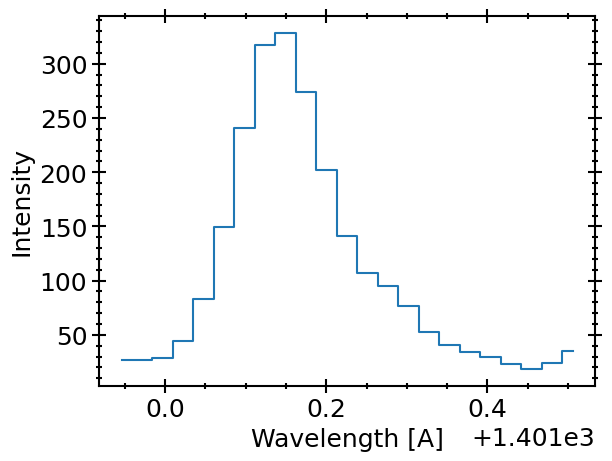

72.94953562704418


In [7]:
### Plot an example to test how well we have isolated the line
plt.plot(ll,yy[49,1551,:], drawstyle='steps-mid')
plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity')
plt.show()

print(np.nanmax(yy[48,1550,:]))

***Notes from Graham***
> - I think that that there are multiple flare regions.
> - We have to carefully select which pixels flare in each line. Since Si IV is stronger we can be more relaxed, 
as there aren't so many very weak profiles even in the pre-flare. For O IV however we should be a bit more conservative.
> - My suggestion is the following:
    
Si IV 1394 (w1 = 1393.4, w2 = 1394.7 seems like a good range):
- Flare region 1: yrange = [180:250]; trange = [1200:1800]
- Flare region 2: yrange = [40:80]; trange = [1400:1800]

Si IV 1402 (w1 = 1402.3, w2 = 1403.5 seems like a good range):
- Flare region 1: yrange = [180:250]; trange = [1200:1800]
- Flare region 2: yrange = [40:80]; trange = [1400:1800]

O IV 1401.2 (w1 = 1400.95, w2 = 1401.5 seems like a good range):
- Flare region 1: yrange = [180:240]; trange = [1300:1700]
- Flare region 2: yrange = [44:80]; trange = [1480:1700]


Note that the Si IV lines do get saturated around the flare peak (esp in the lower ribbon). This means that we might want to have some check in the moments analysis that if the intensity is larger than some threshold, don't include the pixel in the analysis. This threshold seems to be 4000 DN. A simple check is, 

maxint = np.nanmax(profile)<br>
if maxint < 4000:<br>
....do the analysis

---
---
---
### <b style="color:blue"> Set up the data to be saved </b>
> - Create a time array
> - Save tha data as a fits file

***Set up which line to save, and what parts of the field-of-view***

In [11]:
### The filename:
# fname_out = 'SiIV1394_25Oct2014_Region2.fits'
# fname_out = 'SiIV1402_25Oct2014_Region2.fits'
fname_out = 'O_IV1402_25Oct2014_Region2.fits'

### Which time indices
tind1 = 1480
tind2 = 1700

### Which spatial indices
yind1 = 44
yind2 = 80

### Which wavelength indices
lowerlim,upperlim = 1400.95,1401.5  ### O IV 1401.157A 
# lowerlim,upperlim = 1393.4, 1394.7 ### Si IV 1393.755A
# lowerlim,upperlim = 1402.3, 1403.5 ### Si IV 1402.770A

## Select which indices correspond to the lower and upper wavelength values
wind1 = np.abs(wl - lowerlim).argmin()
wind2 = np.abs(wl - upperlim).argmin()

sind = 0

***Create the time arrays***

In [12]:
timer_tmp = sg_dict['hdr']['dateobs'][:,0]
timer = pd.to_datetime(timer_tmp[tind1:tind2+1])

### This gives you
##      delta_t = the difference (in seconds) between successive element in the array
##      delta_t_basem = the difference (in minutes) between each element in the array and the first element
##      delta_t_bases = the difference (in seconds) between each element in the array and the first element 

delta_t = np.zeros([len(timer)], dtype = np.float32)
for ii in range(1,len(delta_t)):

    delta_t[ii] = (timer[ii] - timer[ii-1])/np.timedelta64(1,'s')
delta_t_basem = (timer-timer[0])/np.timedelta64(1,'m')
delta_t_bases = (timer-timer[0])/np.timedelta64(1,'s')
t0 = timer[0]

***Save the data in the fits file***

In [13]:
hdr = fits.Header()

wavelength = sg_dict['wl'][wind1:wind2+1,sind]
data = sg_dict['data'][yind1:yind2+1,tind1:tind2+1,wind1:wind2+1,sind] 
time = delta_t_bases
tref = [str(timer_tmp[tind1])]

hdr['wvlength'] = 'Wavelength, Angstrom'
hdr['time'] = 'Time from reference, s'
hdr['data'] = 'data [slit position, time, wvlength], DN/s/px'
hdr['tref'] = 'Reference time, all times in seconds after this point:'+str(timer_tmp[tind1])
hdr['wavelength indices'] = 'The selected wavelength indices'
hdr['time indices'] = 'The selected time indices'
hdr['slit indices'] = 'The selected indices along the slit'

empty_primary = fits.PrimaryHDU(header=hdr)

image_hdu1 = fits.PrimaryHDU(wavelength,header = hdr)
image_hdu2 = fits.ImageHDU(time)
image_hdu3 = fits.ImageHDU(data) 
image_hdu4 = fits.ImageHDU([wind1,wind2])
image_hdu5 = fits.ImageHDU([tind1,tind2])
image_hdu6 = fits.ImageHDU([yind1,yind2])

hdul = fits.HDUList([image_hdu1,
                     image_hdu3,
                     image_hdu2,
                     image_hdu4,
                     image_hdu5,
                     image_hdu6])
hdul.writeto(fname_out, overwrite=True)